In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import pyfolio as pf
%matplotlib inline

In [2]:
DATA_DIR = 'C:/Users/jgtzsx01/Documents/workspace/zjsxzy_in_js/Research/data/'

In [3]:
fname = '%s/assets.xlsx'%(DATA_DIR)

In [4]:
odf = pd.read_excel(fname, index_col=0)

In [5]:
odf.head()

,881001.WI,HSI.HI,SPX.GI,065.CS,AU9999.SGE,B.IPE,H11025.CSI
2007-01-04,1461.2643,20025.58,1418.34,116.1885,158.58,0.0,1019.2584
2007-01-05,1474.4288,20211.28,1409.71,116.2254,156.94,0.0,1019.3131
2007-01-08,1522.0564,20029.66,1412.84,116.2289,153.72,0.0,1019.4650
2007-01-09,1564.7432,19898.08,1412.11,116.2638,154.45,0.0,1019.5195
2007-01-10,1603.9025,19568.34,1414.85,116.2990,154.34,0.0,1019.5750


In [6]:
def metric(daily_ret):
    an_ret = pf.empyrical.annual_return(daily_ret)
    sharpe = pf.empyrical.sharpe_ratio(daily_ret)
    vol = pf.empyrical.annual_volatility(daily_ret)
    maxdraw = pf.empyrical.max_drawdown(daily_ret)
    print 'Annual return: %.2f%%'%(an_ret*100)
    print 'Sharpe ratio: %.2f'%(sharpe)
    print 'Annual volatility: %.2f%%'%(vol*100)
    print 'Max drawdown: %.2f%%'%(maxdraw*100)

In [7]:
df = odf[['881001.WI', 'HSI.HI', 'SPX.GI', '065.CS', 'AU9999.SGE']]

In [8]:
ret_df = df.pct_change().dropna()

In [107]:
months = pd.Series(ret_df.index.map(lambda x: (x.year, x.month)), index=ret_df.index)
rebalance_dates = months.drop_duplicates(keep='last').index

In [108]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
# drawdown_df = pd.DataFrame(columns=ret_df.columns, index=rebalance_dates)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        K = 20
        past_return = ret_df[ret_df.index <= date][-K:]
        if past_return.shape[0] == K:
            max_drawdown = pd.Series(index=past_return.columns)
            sharpe = pd.Series(index=past_return.columns)
            for col in past_return.columns:
                mdd = pf.empyrical.max_drawdown(past_return[col])
                vol = pf.empyrical.annual_volatility(past_return[col])
                max_drawdown.loc[col] = mdd
                sharpe[col] = pf.empyrical.sharpe_ratio(past_return[col])
#                 drawdown_df.loc[date, col] = mdd
#             wb = -(sharpe ** 2) / max_drawdown
            wb = -1. / max_drawdown
            wb /= wb.sum()

In [109]:
portfolio_ret = (weight * ret_df).sum(axis=1)

In [110]:
portfolio_ret = portfolio_ret[portfolio_ret != 0]

In [111]:
metric(portfolio_ret)

Annual return: 7.40%
Sharpe ratio: 2.09
Annual volatility: 3.44%
Max drawdown: -4.96%


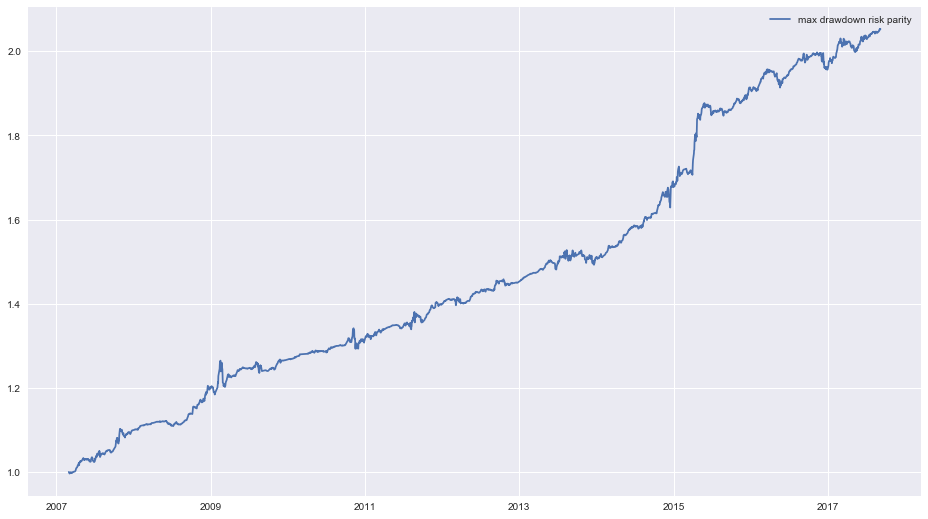

In [112]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='max drawdown risk parity')
plt.legend()

In [199]:
ret = {}
for year in range(2007, 2018):
    returns = portfolio_ret[(portfolio_ret.index >= '%d-01-01'%(year)) & (portfolio_ret.index < '%s-01-01'%(year+1))]
    ret[year] = pf.empyrical.cum_returns_final(returns)

In [200]:
bdf = pd.DataFrame({'ret': ret.values(), 'year': ret.keys()})

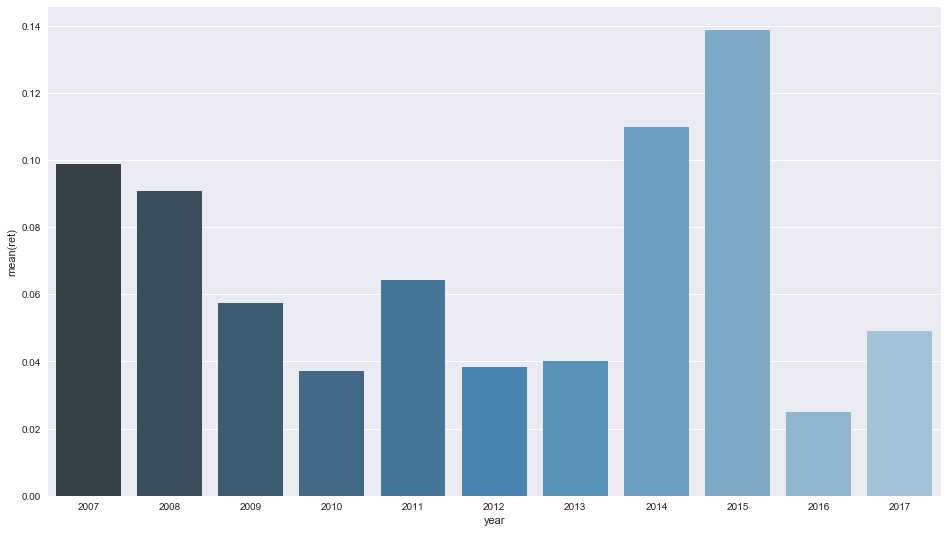

In [201]:
plt.figure(figsize=(16, 9))
sns.barplot(x='year', y='ret', data=bdf, palette="Blues_d")

In [227]:
weight = pd.DataFrame(columns=ret_df.columns, index=ret_df.index)
# drawdown_df = pd.DataFrame(columns=ret_df.columns, index=rebalance_dates)
wb = np.zeros(ret_df.shape[1])
for date in ret_df.index:
    weight.loc[date] = wb
    if date in rebalance_dates:
        K = 20
        past_return = ret_df[ret_df.index <= date][-K:]
        if past_return.shape[0] == K:
            max_drawdown = pd.Series(index=past_return.columns)
            sharpe = pd.Series(index=past_return.columns)
            for col in past_return.columns:
                mdd = pf.empyrical.max_drawdown(past_return[col])
                vol = pf.empyrical.annual_volatility(past_return[col])
                max_drawdown.loc[col] = mdd if mdd < 0 else -0.00001
                sharpe[col] = pf.empyrical.sharpe_ratio(past_return[col])
#                 drawdown_df.loc[date, col] = mdd

            sharpe[sharpe < 0] = 0
            prev_wb = wb
            wb = -sharpe / max_drawdown
#             if date.year == 2010 and date.month == 2:
#                 print date, sharpe, max_drawdown
#                 break
            if wb.sum() != 0:
                wb /= wb.sum()
                if wb[3] < 0.5:
                    wb[3] = wb.sum()
                    wb /= wb.sum()
            else:
                wb = prev_wb

In [229]:
portfolio_ret2 = (weight * ret_df).sum(axis=1)

In [230]:
portfolio_ret2 = portfolio_ret2[portfolio_ret2 != 0]

In [231]:
metric(portfolio_ret2)

Annual return: 10.38%
Sharpe ratio: 1.93
Annual volatility: 5.19%
Max drawdown: -8.19%


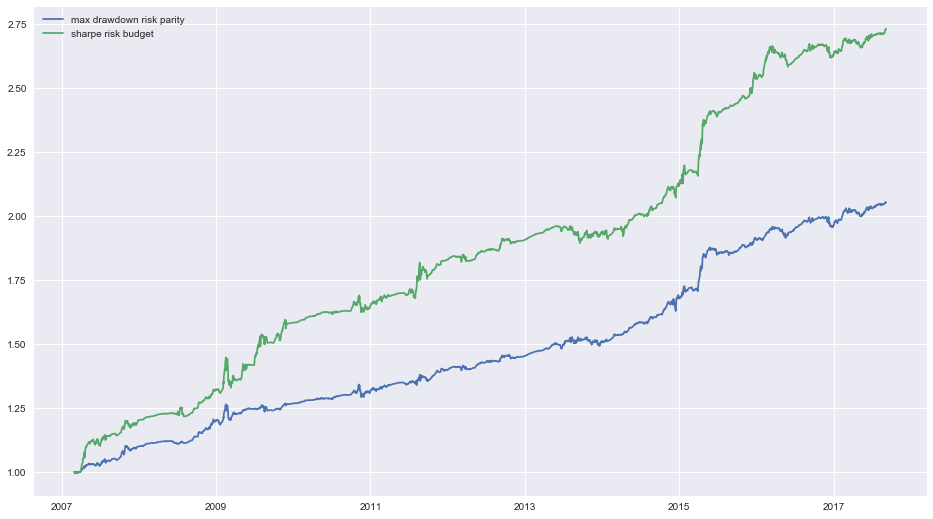

In [232]:
plt.figure(figsize=(16, 9))
plt.plot((1+portfolio_ret).cumprod(), label='max drawdown risk parity')
plt.plot((1+portfolio_ret2).cumprod(), label='sharpe risk budget')
plt.legend()

In [196]:
ret = {}
for year in range(2007, 2018):
    returns = portfolio_ret2[(portfolio_ret2.index >= '%d-01-01'%(year)) & (portfolio_ret2.index < '%s-01-01'%(year+1))]
    ret[year] = pf.empyrical.cum_returns_final(returns)

In [197]:
bdf = pd.DataFrame({'ret': ret.values(), 'year': ret.keys()})

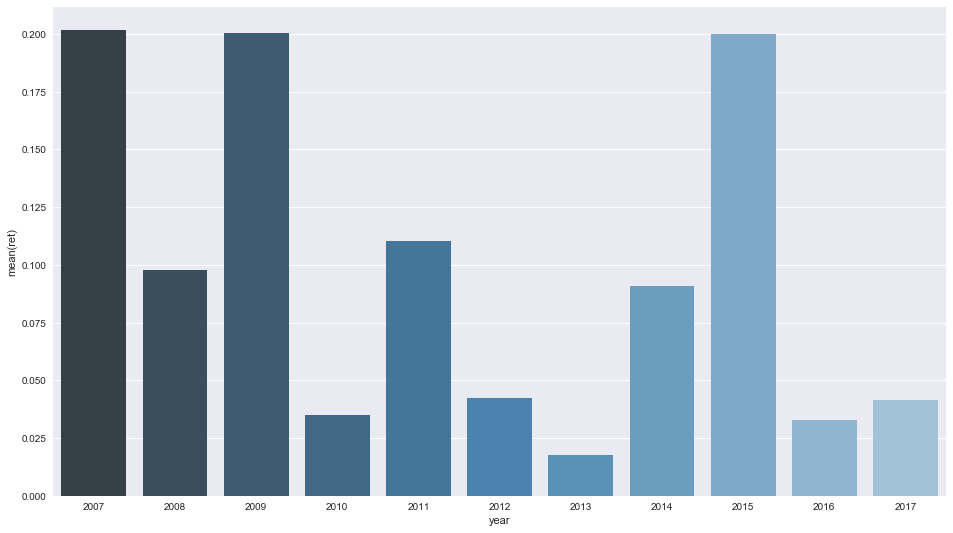

In [198]:
plt.figure(figsize=(16, 9))
sns.barplot(x='year', y='ret', data=bdf, palette="Blues_d")

In [233]:
bdf = pd.DataFrame(portfolio_ret2.resample('M').apply(lambda x: pf.empyrical.cum_returns_final(x)))

In [234]:
bdf.columns = ['ret']
bdf['month'] = bdf.index

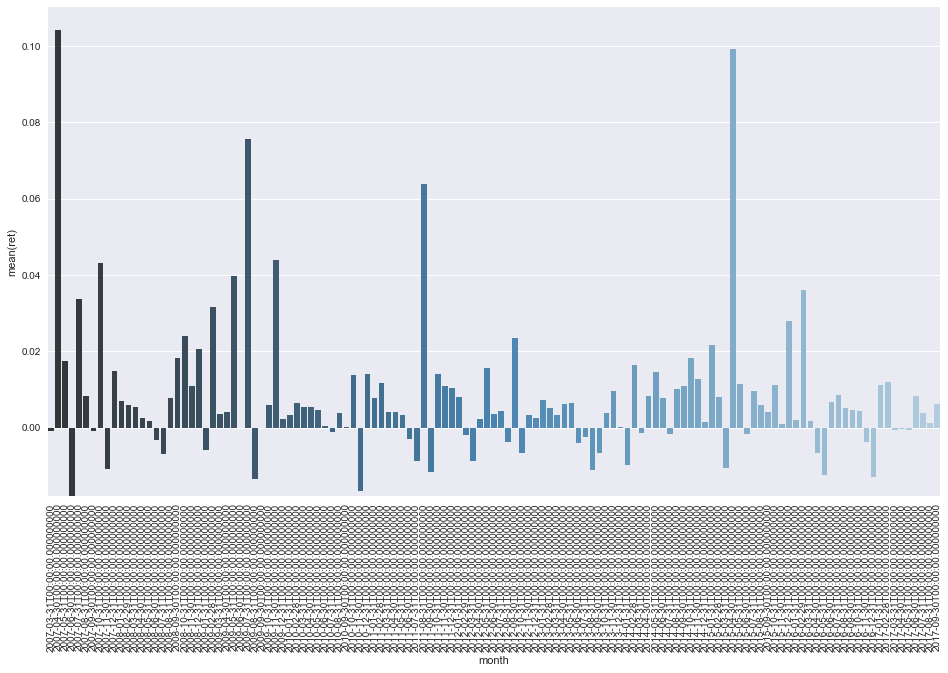

In [237]:
plt.figure(figsize=(16, 9))
plt.xticks(rotation=90)
sns.barplot(x='month', y='ret', data=bdf, palette="Blues_d")

In [236]:
portfolio_ret2.resample('M').apply(lambda x: pf.empyrical.cum_returns_final(x)).to_csv('C:/Users/jgtzsx01/Desktop/rp.csv')